<a href="https://colab.research.google.com/github/as4401s/AI-for-medicine/blob/master/Copy_of_toy_example_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we download and import all neccessary packages

In [ ]:
!git clone --depth=1 https://github.com/ntapiam/dagstuhl.git
%cd dagstuhl

fatal: destination path 'dagstuhl' already exists and is not an empty directory.
/content/dagstuhl


In [ ]:
import isstorch  # Feature extraction procedure

from tqdm.notebook import trange # Pretty printing

# Some utilities
from utils import generate_examples, compute_signatures

# Import PyTorch and shorthand some components
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Utils for plotting
import matplotlib.pyplot as plt
import seaborn as sns

Set the default `torch` device depending on whether there is a GPU available.
You can change this by going to `Runtime > Change runtime type` and selecting among the available accelerators (None means CPU).

We also run a random example to measure speed and check that everything is working OK.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

x = torch.randn(1000, 100, device=device)
if torch.cuda.is_available():
  with torch.no_grad():
    %time isstorch.compute(x); torch.cuda.synchronize('cuda')
x = x.to('cpu')
with torch.no_grad():
  %time isstorch.compute(x);

CPU times: user 4.06 ms, sys: 2.02 ms, total: 6.09 ms
Wall time: 6.09 ms
CPU times: user 231 ms, sys: 67 ms, total: 298 ms
Wall time: 293 ms


Let's look at some samples. The function `generate_samples` outputs a different set of data each time.

The dataset is generated from an ARMA(1,1) model with mean equal to 0.5 and different parameters for each class.
More precisely, each sample in the class is generated by the recursion
$$
  x_{t+1} = \phi x_t + 0.5 + \epsilon_t + \theta\epsilon_{t-1}
$$
where $\phi$ and $\theta$ are class dependent.

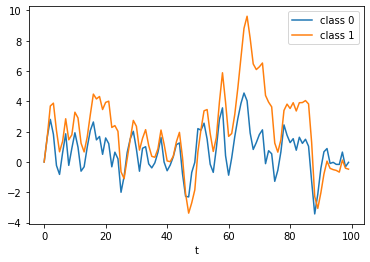

In [ ]:
X, labels = generate_examples()
plt.plot(range(100), X[0], label="class 0")
plt.plot(range(100), X[500], label="class 1")
plt.xlabel('t')
plt.legend()
plt.show()

Now, we compute the signature features using our `pytorch` implementation.

In [ ]:
with torch.no_grad():
  %time sigs = compute_signatures(X, level=4) # Hyperparameter chosen here!
                                              # Play with it and see how it
                                              # changes the results

sigs.shape # Check how many features we obtain

CPU times: user 559 ms, sys: 2.99 ms, total: 562 ms
Wall time: 563 ms


torch.Size([1000, 15])

In order to train and test our Neural Network, we split the data into a training set and a test set using the auxiliary function `train_test_split` from the `sklearn` package. The stratification ensures a balanced distribution of both classes in each split.

We use 70% of the data for training. Try modifying this value to see how the results change.

We need to wrap the data in a PyTorch `DataLoader` [(docs)](https://pytorch.org/docs/stable/data.html).
We also load the data in batches.

In [ ]:
train_sigs, test_sigs, train_labels, test_labels = train_test_split(sigs, labels, stratify=labels, train_size=0.7)
train_dataloader = DataLoader(TensorDataset(train_sigs, train_labels), batch_size=100)
test_dataloader = DataLoader(TensorDataset(test_sigs, test_labels), batch_size=100)

We build our model using by subclassing `torch.nn.Module`.

To see all possible layers and activations, please see the `torch.nn` [(docs)](https://pytorch.org/docs/stable/nn.html).

In [ ]:
### FILL IN THIS CELL
## Write a class implementing a Dense (fully connected) feed forward Neural Network.
## Some pointers:
## - Make the number of input features a parameter, we'll need it later
## - Hint: Use the `torch.nn.Sequential` container to build the layers
## - Last layer should have two outputs and apply log(Softmax) to them (PyTorch requirement)
## - PyTorch needs you to implement the forward(self, X) method in order forward
##   propagate the features through the network.

class Feedforward(torch.nn.Module):
  def __init__(self,input_size,hidden_size):
    super (Feedforward,self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.h11 = torch.nn.Linear(self.input_size,self.hidden_size)
    self.relu = torch.nn.ReLU()
    self.h12 = torch.nn.Linear(self.hidden_size, self.hidden_size)
    self.h13 = torch.nn.Linear(self.hidden_size,self.hidden_size)
    self.output_layer = torch.nn.Linear(self.hidden_size, 2)
    self.output_activation = torch.nn.Softmax()

  def forward(self, x):
     hidden = self.h11(x)
     relu = self.relu(hidden)
     hidden2 = self.h12(relu)
     relu2 = self.relu(hidden2)
     hidden3 = self.h13(relu2)
     relu3 = self.relu(hidden3)
     output = self.output_layer(relu3)
     output_activation = self.output_activation(output)

     return output_activation


Next, we set up the training and testing loops

In [ ]:
def train_loop(model, dataloader, loss_fn, optimizer, device):
    
    ### FILL IN
    ## Some pointers:
    ## - Load the data in batches by iterating through `dataloader`
    ## - Make a prediction using `model` and evaluate it using `loss_fn`
    ## - Backpropagate the error through the network
    ## - Finally, use `optimizer` to modify the weights (remember to reset them at each batch)

    for x,y in dataloader:
      x = x.to(device)
      y = y.to(device)
      pred = model(x)

      loss = loss_fn(pred.squeeze(), y)
      loss.backward()
      optimizer.step()

def test_loop(model, dataloader, loss_fn, device):
    ### FILL IN
    ## Some pointers:
    ## - Load the data by iterating through `dataloader`
    ## - Make a prediction using `model` and evaluate it using `loss_fn`
    ## - Compute the number of correct guesses by comparing your predictions to the 'ground truth'
    ## - Return the accuracy and average loss value of your model.
    total_samples, batches = len(dataloader.dataset)
    with torch.no_grad():
      for x,y in dataloader:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        agree += (pred.argmax(dim=1) == y).type(torch.float).sum()
      

        loss += loss_fn(pred.squeeze(), y)
        loss.backward()
        optimizer.step()

  
      return agree/total_samples, loss/total_samples
    return accuracy, avg_loss

Setup our model, loss function and optimizer [(docs)](https://pytorch.org/docs/stable/optim.html#algorithms). 

Train the network and output the result.

In [ ]:
%%time
model = Feedforward(1,20).to(device) ## FILL IN (remember to call .to(device) if training on the GPU!)
optimizer = Adam(model.parameters(), lr=1e-3) # One possible choice of optimizer
loss_fn = nn.NLLLoss() ## We choose the Negative Log Likelihood loss

epochs = 500  # Hyperparameter, feel free to change it
losses = [] # Record the losses during training for some a posteriori analysis
accuracies = [] # Same with accuracies

# The following is some pretty printing
with trange(epochs) as pbar:
    for t in pbar:
        train_loop(model, train_dataloader, loss_fn, optimizer, device)
        acc, avg_loss = test_loop(model, test_dataloader, loss_fn, device)
        accuracies.append(acc)
        losses.append(avg_loss)
        pbar.set_description(f"Training")
        pbar.set_postfix(loss=avg_loss, accuracy=acc)

# Run the test loop once more to verify our accuracy
acc, avg_loss = test_loop(model, test_dataloader, loss_fn, device)
print(f"\nDone! Accuraccy: {acc:.2%}, Loss: {avg_loss:f}")

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


TypeError: ignored

Now, we can make a predicition on our test data (or even new inputs), which will be given as a probability distribution over class labels.

Note that we apply the exponential mapping in order to obtain (true) probabilities, as the network outputs negative log probas.

In [ ]:
preds = model(test_sigs[:10]).exp()

RuntimeError: ignored

We check that they sum to 1 for each example.

In [ ]:
torch.allclose(preds.sum(dim=1), torch.ones(10)) # Need to use `allclose` to account for floating point errors

 The predicted label is the one with the highest probability.

In [ ]:
preds.argmax(dim=1), test_labels[:10]

The following cell plots the evolution of the total loss and accuracy across training epochs.

In [ ]:
sns.set_theme() # Prettify plots
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(epochs), losses, color='tab:red')
ax2.plot(range(epochs), accuracies, color='tab:blue')
ax1.set_xlabel('epochs')
ax1.set_ylabel('losses')
ax2.set_ylim(bottom=0, top=1)
ax2.set_ylabel('accuracy')
fig.tight_layout()
plt.plot()

Next, we compare with the same model but trained on raw time-series data.

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(X.flatten(start_dim=1), labels, stratify=labels, train_size=0.7)
train_dataloader = DataLoader(TensorDataset(train_data, train_labels), batch_size=100)
test_dataloader = DataLoader(TensorDataset(test_data, test_labels), batch_size=100)

In [ ]:
%%time
in_features=100
new_model = ## Use the same model as before with the appropriate parameteres
new_optimizer = Adam(new_model.parameters(), lr=1e-3) # Initialize optimizer
new_loss_fn = nn.NLLLoss()

with trange(epochs) as pbar:
    for t in pbar:
        train_loop(new_model, train_dataloader, new_loss_fn, new_optimizer, device)
        acc, avg_loss = test_loop(new_model, test_dataloader, new_loss_fn, device)
        pbar.set_description(f"Training")
        pbar.set_postfix(loss=avg_loss, accuracy=acc)

acc, avg_loss = test_loop(new_model, test_dataloader, new_loss_fn, device)
print(f"\nDone! Accuraccy: {acc:.2%}, Loss: {avg_loss:f}")